E20. project-Segmentation_Map
===
---

## 목표
Segmentation Map 데이터를 이용하여 Pix2Pix를 학습시켜 결과이미지를 출력해보자.

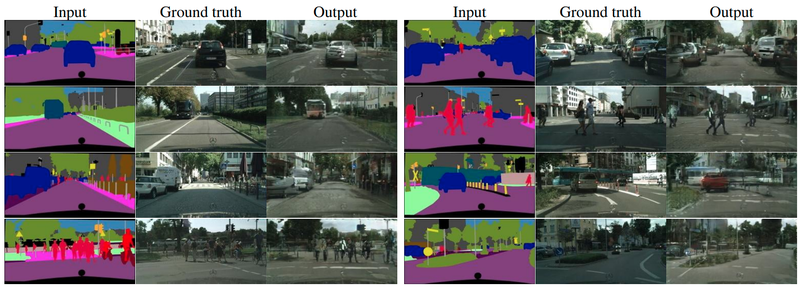

<br/>
<br/>

#### 데이터 불러오기 및 데이터 수 확인

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


> 1000개 이미지가 있음을 확인

#### 각각의 이미지들이 어떻게 생겼는지 확인( 임의로 6장을 선택하여 시각화)

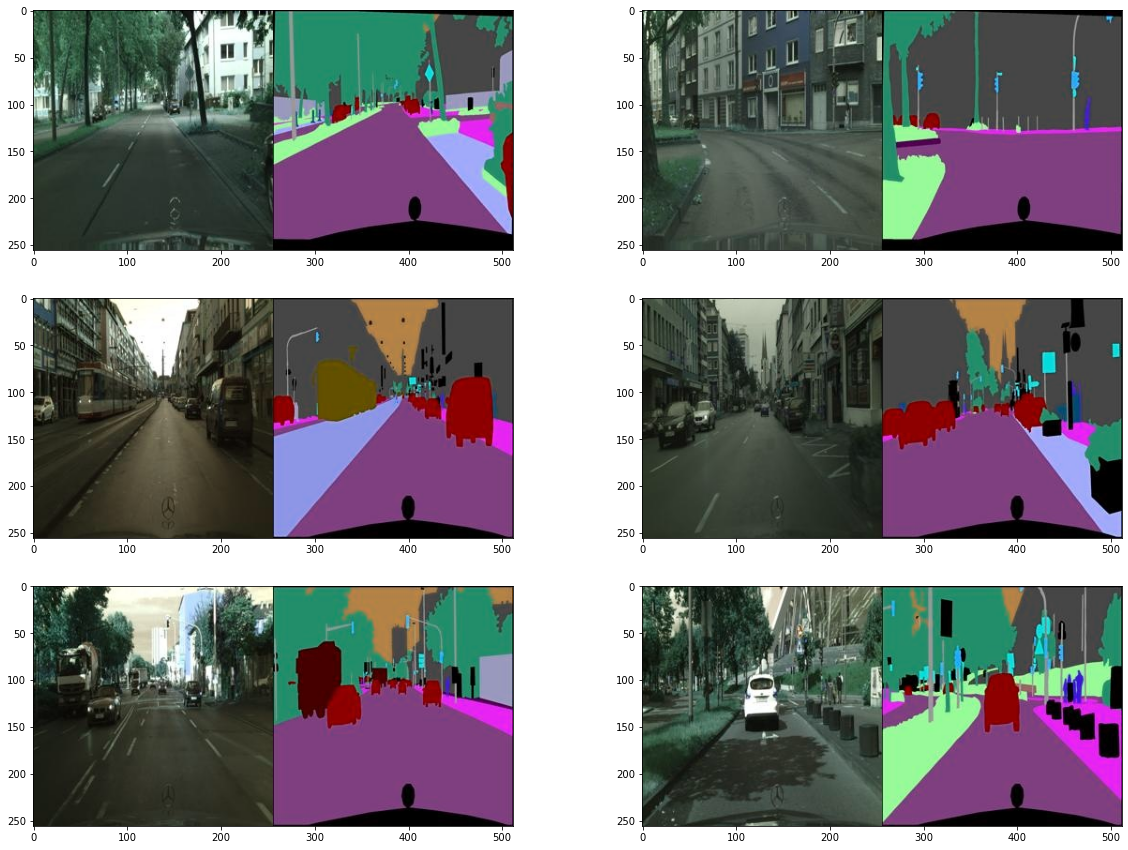

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

> 실제 사진과 함께 레이블 정보 이미지가 함께 붙어 있음

#### 이미지를 하나 열어 아래와 같이 크기를 확인

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> (256, 512, 3)으로 확인되어 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할이 필요함

#### (256, 256, 3) 크기의 2개 이미지로 분할

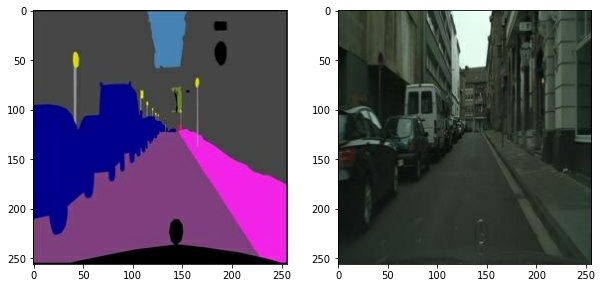

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :]  
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

#### 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


### mission 1. 필수로 수행해야할 Agumentation :: 아래의 5가지를 적용
- tf.pad :: 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용

- tf.image.random_crop :: (256,256,6) 크기를 가진 이미지를 임의로 잘라냄

- tf.image.random_flip_left_right :: 50% 확률로 가로로 뒤집음

- tf.image.random_flip_up_down :: 50% 확률로 세로로 뒤집음

- tf.image.rot90 ::  50% 확률로 회전시킴

#### Agumentation을 수행한 이미지들을 출력

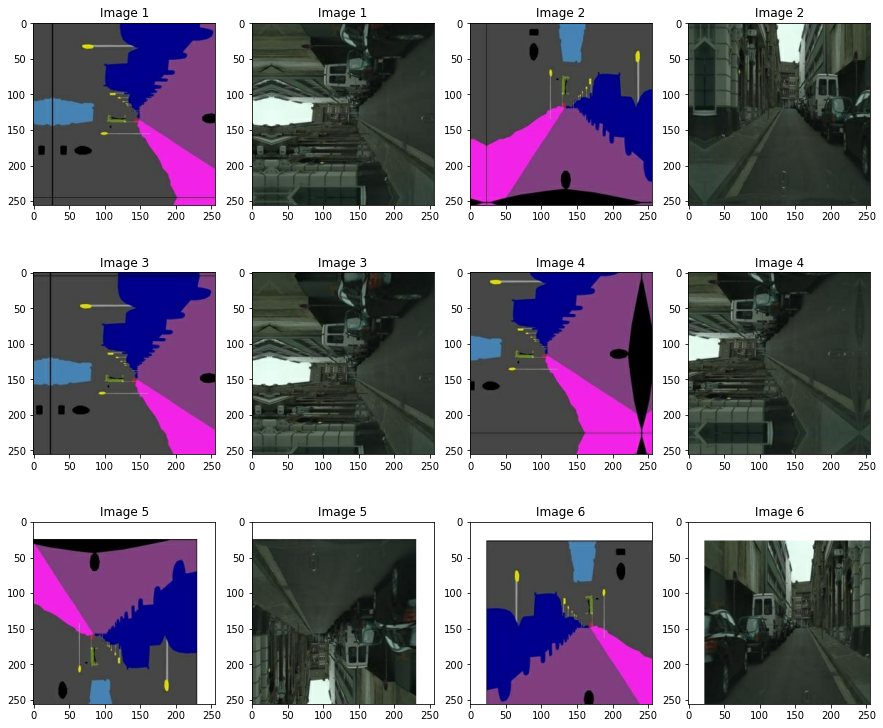

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

#### 잘 적용되었는지 하나의 이미지만 시각화하여 확인

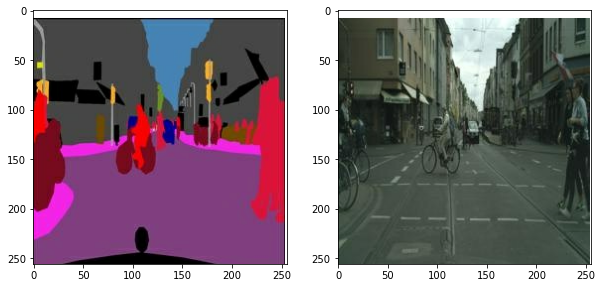

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 구현하기

#### 1) "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 만들기

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


#### 2) 여러 번 가져다가 Encoder로 만들어 사용

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


#### 3) Encoder model설계

In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

> 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있음

### Decoder를 구현

#### 1) Decoder 블럭 만들기
#### 2) Decoder 블럭 쌓기

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


> 처음 세 개의 블록에서만 `Dropout`을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있음

#### Decoder model 설계

In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

> (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었음.

#### tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


> Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 학습시켜야 함

#### Encoder 및 Decoder에 사용되는 기본적인 블록

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


#### U-Net Generator를 정의 (skip connection)

In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### mission 2. U-net generator 사용

#### U-net의 출력을 확인

In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

#### Discriminator에 사용할 기본적인 블록 만들기

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


#### 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인

In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


#### Discriminator를 만들어보기

In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


#### 각 블록의 출력 크기가 알맞게 되었는지 확인

In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

> 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치함을 확인할 수 있음

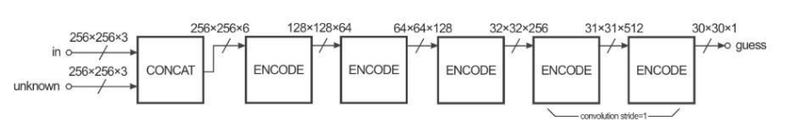

#### (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화

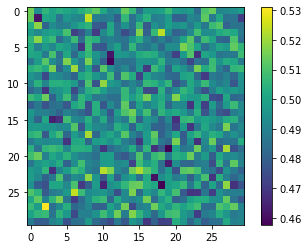

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

#### 두 가지 손실 함수를 모두 사용

In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


> Generator 및 Discriminator의 손실 계산을 각각 정의하였다.

#### 사용할 optimizer는 논문과 동일하게 설정

In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


#### 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


### Mission 5. 중간 손실 값에 대한 로그 남기기

#### 150 epoch 학습

In [25]:
EPOCHS = 150

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
            

EPOCH[1] - STEP[10]                     
Generator_loss:0.9450                     
L1_loss:0.2995                     
Discriminator_loss:1.3058

EPOCH[1] - STEP[20]                     
Generator_loss:1.0184                     
L1_loss:0.2265                     
Discriminator_loss:1.3417

EPOCH[1] - STEP[30]                     
Generator_loss:0.8414                     
L1_loss:0.2134                     
Discriminator_loss:1.3003

EPOCH[1] - STEP[40]                     
Generator_loss:0.8633                     
L1_loss:0.2045                     
Discriminator_loss:1.2087

EPOCH[1] - STEP[50]                     
Generator_loss:0.8910                     
L1_loss:0.1728                     
Discriminator_loss:1.3747

EPOCH[1] - STEP[60]                     
Generator_loss:0.8321                     
L1_loss:0.1566                     
Discriminator_loss:1.2119

EPOCH[1] - STEP[70]                     
Generator_loss:0.9612                     
L1_loss:0.2002                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.0199                     
L1_loss:0.1845                     
Discriminator_loss:0.7974

EPOCH[3] - STEP[80]                     
Generator_loss:1.2707                     
L1_loss:0.1680                     
Discriminator_loss:0.7670

EPOCH[3] - STEP[90]                     
Generator_loss:0.8561                     
L1_loss:0.1719                     
Discriminator_loss:1.0085

EPOCH[3] - STEP[100]                     
Generator_loss:1.7460                     
L1_loss:0.1759                     
Discriminator_loss:0.4804

EPOCH[3] - STEP[110]                     
Generator_loss:0.6630                     
L1_loss:0.1677                     
Discriminator_loss:1.0508

EPOCH[3] - STEP[120]                     
Generator_loss:1.2256                     
L1_loss:0.1543                     
Discriminator_loss:0.9562

EPOCH[3] - STEP[130]                     
Generator_loss:2.5227                     
L1_loss:0.1709                

EPOCH[5] - STEP[130]                     
Generator_loss:2.5790                     
L1_loss:0.1833                     
Discriminator_loss:1.1398

EPOCH[5] - STEP[140]                     
Generator_loss:1.2691                     
L1_loss:0.1712                     
Discriminator_loss:0.9596

EPOCH[5] - STEP[150]                     
Generator_loss:1.7026                     
L1_loss:0.2070                     
Discriminator_loss:1.8762

EPOCH[5] - STEP[160]                     
Generator_loss:1.6547                     
L1_loss:0.1507                     
Discriminator_loss:1.4273

EPOCH[5] - STEP[170]                     
Generator_loss:2.0068                     
L1_loss:0.2142                     
Discriminator_loss:0.5503

EPOCH[5] - STEP[180]                     
Generator_loss:1.2164                     
L1_loss:0.1680                     
Discriminator_loss:1.2301

EPOCH[5] - STEP[190]                     
Generator_loss:1.7729                     
L1_loss:0.1698             

EPOCH[7] - STEP[190]                     
Generator_loss:1.9624                     
L1_loss:0.1550                     
Discriminator_loss:0.4301

EPOCH[7] - STEP[200]                     
Generator_loss:1.8266                     
L1_loss:0.1540                     
Discriminator_loss:1.1290

EPOCH[7] - STEP[210]                     
Generator_loss:1.1452                     
L1_loss:0.2144                     
Discriminator_loss:0.8186

EPOCH[7] - STEP[220]                     
Generator_loss:0.5773                     
L1_loss:0.1623                     
Discriminator_loss:1.0417

EPOCH[7] - STEP[230]                     
Generator_loss:1.4725                     
L1_loss:0.1906                     
Discriminator_loss:0.4876

EPOCH[7] - STEP[240]                     
Generator_loss:1.9043                     
L1_loss:0.1749                     
Discriminator_loss:0.5655

EPOCH[7] - STEP[250]                     
Generator_loss:1.2463                     
L1_loss:0.1944             

EPOCH[9] - STEP[250]                     
Generator_loss:1.1166                     
L1_loss:0.2008                     
Discriminator_loss:0.5894

EPOCH[10] - STEP[10]                     
Generator_loss:1.9346                     
L1_loss:0.1912                     
Discriminator_loss:1.2223

EPOCH[10] - STEP[20]                     
Generator_loss:2.2363                     
L1_loss:0.1794                     
Discriminator_loss:0.3035

EPOCH[10] - STEP[30]                     
Generator_loss:2.0235                     
L1_loss:0.1335                     
Discriminator_loss:1.7056

EPOCH[10] - STEP[40]                     
Generator_loss:1.2936                     
L1_loss:0.2012                     
Discriminator_loss:0.5662

EPOCH[10] - STEP[50]                     
Generator_loss:1.3974                     
L1_loss:0.1656                     
Discriminator_loss:0.6266

EPOCH[10] - STEP[60]                     
Generator_loss:1.5852                     
L1_loss:0.1853             

EPOCH[12] - STEP[60]                     
Generator_loss:1.5541                     
L1_loss:0.1878                     
Discriminator_loss:0.7409

EPOCH[12] - STEP[70]                     
Generator_loss:0.7690                     
L1_loss:0.1553                     
Discriminator_loss:2.3336

EPOCH[12] - STEP[80]                     
Generator_loss:2.6457                     
L1_loss:0.1598                     
Discriminator_loss:1.1666

EPOCH[12] - STEP[90]                     
Generator_loss:0.9274                     
L1_loss:0.1695                     
Discriminator_loss:1.2500

EPOCH[12] - STEP[100]                     
Generator_loss:1.2978                     
L1_loss:0.1787                     
Discriminator_loss:0.6466

EPOCH[12] - STEP[110]                     
Generator_loss:1.0899                     
L1_loss:0.1778                     
Discriminator_loss:1.4061

EPOCH[12] - STEP[120]                     
Generator_loss:1.0970                     
L1_loss:0.1932          

EPOCH[14] - STEP[120]                     
Generator_loss:2.2330                     
L1_loss:0.1905                     
Discriminator_loss:0.5325

EPOCH[14] - STEP[130]                     
Generator_loss:2.7617                     
L1_loss:0.1986                     
Discriminator_loss:0.2565

EPOCH[14] - STEP[140]                     
Generator_loss:1.1370                     
L1_loss:0.1800                     
Discriminator_loss:0.5517

EPOCH[14] - STEP[150]                     
Generator_loss:0.9549                     
L1_loss:0.1818                     
Discriminator_loss:0.6527

EPOCH[14] - STEP[160]                     
Generator_loss:1.2612                     
L1_loss:0.1652                     
Discriminator_loss:0.6149

EPOCH[14] - STEP[170]                     
Generator_loss:0.9141                     
L1_loss:0.1727                     
Discriminator_loss:1.4738

EPOCH[14] - STEP[180]                     
Generator_loss:1.3620                     
L1_loss:0.1786      

EPOCH[16] - STEP[180]                     
Generator_loss:1.4228                     
L1_loss:0.1666                     
Discriminator_loss:1.7330

EPOCH[16] - STEP[190]                     
Generator_loss:1.2215                     
L1_loss:0.1889                     
Discriminator_loss:0.5537

EPOCH[16] - STEP[200]                     
Generator_loss:3.2243                     
L1_loss:0.1590                     
Discriminator_loss:1.9244

EPOCH[16] - STEP[210]                     
Generator_loss:1.8485                     
L1_loss:0.1875                     
Discriminator_loss:1.2592

EPOCH[16] - STEP[220]                     
Generator_loss:0.7894                     
L1_loss:0.1901                     
Discriminator_loss:0.7670

EPOCH[16] - STEP[230]                     
Generator_loss:1.7547                     
L1_loss:0.1851                     
Discriminator_loss:1.6417

EPOCH[16] - STEP[240]                     
Generator_loss:1.3820                     
L1_loss:0.1522      

EPOCH[18] - STEP[240]                     
Generator_loss:2.1950                     
L1_loss:0.1631                     
Discriminator_loss:2.1130

EPOCH[18] - STEP[250]                     
Generator_loss:2.3435                     
L1_loss:0.1971                     
Discriminator_loss:0.2074

EPOCH[19] - STEP[10]                     
Generator_loss:1.5070                     
L1_loss:0.1954                     
Discriminator_loss:0.5885

EPOCH[19] - STEP[20]                     
Generator_loss:1.9778                     
L1_loss:0.2003                     
Discriminator_loss:0.2911

EPOCH[19] - STEP[30]                     
Generator_loss:0.3379                     
L1_loss:0.1680                     
Discriminator_loss:1.5143

EPOCH[19] - STEP[40]                     
Generator_loss:1.0506                     
L1_loss:0.1836                     
Discriminator_loss:0.5419

EPOCH[19] - STEP[50]                     
Generator_loss:0.5406                     
L1_loss:0.1582           

EPOCH[21] - STEP[50]                     
Generator_loss:0.8661                     
L1_loss:0.1962                     
Discriminator_loss:1.1480

EPOCH[21] - STEP[60]                     
Generator_loss:1.3150                     
L1_loss:0.2144                     
Discriminator_loss:0.4261

EPOCH[21] - STEP[70]                     
Generator_loss:1.1785                     
L1_loss:0.1492                     
Discriminator_loss:1.9240

EPOCH[21] - STEP[80]                     
Generator_loss:1.6513                     
L1_loss:0.2066                     
Discriminator_loss:0.3487

EPOCH[21] - STEP[90]                     
Generator_loss:1.3975                     
L1_loss:0.1986                     
Discriminator_loss:0.4051

EPOCH[21] - STEP[100]                     
Generator_loss:1.3033                     
L1_loss:0.1557                     
Discriminator_loss:1.7494

EPOCH[21] - STEP[110]                     
Generator_loss:1.0150                     
L1_loss:0.1572           

EPOCH[23] - STEP[110]                     
Generator_loss:1.7847                     
L1_loss:0.1923                     
Discriminator_loss:1.6325

EPOCH[23] - STEP[120]                     
Generator_loss:2.4657                     
L1_loss:0.1524                     
Discriminator_loss:0.7257

EPOCH[23] - STEP[130]                     
Generator_loss:2.3208                     
L1_loss:0.1901                     
Discriminator_loss:0.2265

EPOCH[23] - STEP[140]                     
Generator_loss:0.8073                     
L1_loss:0.2272                     
Discriminator_loss:0.7292

EPOCH[23] - STEP[150]                     
Generator_loss:1.4839                     
L1_loss:0.2225                     
Discriminator_loss:0.4138

EPOCH[23] - STEP[160]                     
Generator_loss:0.8082                     
L1_loss:0.1894                     
Discriminator_loss:1.2981

EPOCH[23] - STEP[170]                     
Generator_loss:1.4440                     
L1_loss:0.1418      

EPOCH[25] - STEP[170]                     
Generator_loss:0.3563                     
L1_loss:0.1789                     
Discriminator_loss:1.6612

EPOCH[25] - STEP[180]                     
Generator_loss:1.2201                     
L1_loss:0.1912                     
Discriminator_loss:0.6755

EPOCH[25] - STEP[190]                     
Generator_loss:1.4450                     
L1_loss:0.1784                     
Discriminator_loss:0.5265

EPOCH[25] - STEP[200]                     
Generator_loss:1.2237                     
L1_loss:0.1803                     
Discriminator_loss:1.1618

EPOCH[25] - STEP[210]                     
Generator_loss:0.7945                     
L1_loss:0.2173                     
Discriminator_loss:0.8747

EPOCH[25] - STEP[220]                     
Generator_loss:1.3843                     
L1_loss:0.1542                     
Discriminator_loss:1.9048

EPOCH[25] - STEP[230]                     
Generator_loss:1.3659                     
L1_loss:0.1604      

EPOCH[27] - STEP[230]                     
Generator_loss:1.7719                     
L1_loss:0.2054                     
Discriminator_loss:0.9712

EPOCH[27] - STEP[240]                     
Generator_loss:1.5457                     
L1_loss:0.1449                     
Discriminator_loss:1.2678

EPOCH[27] - STEP[250]                     
Generator_loss:1.3982                     
L1_loss:0.1844                     
Discriminator_loss:0.3836

EPOCH[28] - STEP[10]                     
Generator_loss:1.5223                     
L1_loss:0.2119                     
Discriminator_loss:0.3849

EPOCH[28] - STEP[20]                     
Generator_loss:1.3588                     
L1_loss:0.2020                     
Discriminator_loss:0.3726

EPOCH[28] - STEP[30]                     
Generator_loss:1.4233                     
L1_loss:0.1661                     
Discriminator_loss:0.4541

EPOCH[28] - STEP[40]                     
Generator_loss:2.0430                     
L1_loss:0.1862          

EPOCH[30] - STEP[40]                     
Generator_loss:2.0969                     
L1_loss:0.1849                     
Discriminator_loss:0.2704

EPOCH[30] - STEP[50]                     
Generator_loss:1.2078                     
L1_loss:0.1702                     
Discriminator_loss:1.0800

EPOCH[30] - STEP[60]                     
Generator_loss:1.9311                     
L1_loss:0.1734                     
Discriminator_loss:0.6585

EPOCH[30] - STEP[70]                     
Generator_loss:2.1319                     
L1_loss:0.1617                     
Discriminator_loss:0.7490

EPOCH[30] - STEP[80]                     
Generator_loss:1.8918                     
L1_loss:0.1784                     
Discriminator_loss:0.4973

EPOCH[30] - STEP[90]                     
Generator_loss:2.0817                     
L1_loss:0.1465                     
Discriminator_loss:0.5965

EPOCH[30] - STEP[100]                     
Generator_loss:1.3436                     
L1_loss:0.1832            

EPOCH[32] - STEP[100]                     
Generator_loss:0.7726                     
L1_loss:0.1955                     
Discriminator_loss:0.7025

EPOCH[32] - STEP[110]                     
Generator_loss:1.2581                     
L1_loss:0.1846                     
Discriminator_loss:0.4223

EPOCH[32] - STEP[120]                     
Generator_loss:0.8555                     
L1_loss:0.1725                     
Discriminator_loss:0.7447

EPOCH[32] - STEP[130]                     
Generator_loss:2.8834                     
L1_loss:0.1832                     
Discriminator_loss:2.2368

EPOCH[32] - STEP[140]                     
Generator_loss:0.7316                     
L1_loss:0.1835                     
Discriminator_loss:0.7780

EPOCH[32] - STEP[150]                     
Generator_loss:1.9078                     
L1_loss:0.1567                     
Discriminator_loss:1.6055

EPOCH[32] - STEP[160]                     
Generator_loss:1.5004                     
L1_loss:0.1840      

EPOCH[34] - STEP[160]                     
Generator_loss:1.0418                     
L1_loss:0.1578                     
Discriminator_loss:0.7158

EPOCH[34] - STEP[170]                     
Generator_loss:1.2508                     
L1_loss:0.1631                     
Discriminator_loss:1.3518

EPOCH[34] - STEP[180]                     
Generator_loss:1.2164                     
L1_loss:0.1734                     
Discriminator_loss:0.5269

EPOCH[34] - STEP[190]                     
Generator_loss:1.4790                     
L1_loss:0.1921                     
Discriminator_loss:1.1686

EPOCH[34] - STEP[200]                     
Generator_loss:1.6670                     
L1_loss:0.1860                     
Discriminator_loss:1.0859

EPOCH[34] - STEP[210]                     
Generator_loss:1.8544                     
L1_loss:0.1719                     
Discriminator_loss:0.3477

EPOCH[34] - STEP[220]                     
Generator_loss:0.4669                     
L1_loss:0.1837      

EPOCH[36] - STEP[220]                     
Generator_loss:1.4158                     
L1_loss:0.1502                     
Discriminator_loss:1.0081

EPOCH[36] - STEP[230]                     
Generator_loss:1.9215                     
L1_loss:0.1479                     
Discriminator_loss:1.4061

EPOCH[36] - STEP[240]                     
Generator_loss:2.1883                     
L1_loss:0.1537                     
Discriminator_loss:0.6907

EPOCH[36] - STEP[250]                     
Generator_loss:1.8631                     
L1_loss:0.1572                     
Discriminator_loss:1.9136

EPOCH[37] - STEP[10]                     
Generator_loss:1.5828                     
L1_loss:0.1630                     
Discriminator_loss:1.8265

EPOCH[37] - STEP[20]                     
Generator_loss:0.8740                     
L1_loss:0.1949                     
Discriminator_loss:0.7851

EPOCH[37] - STEP[30]                     
Generator_loss:1.6452                     
L1_loss:0.1709         

EPOCH[39] - STEP[30]                     
Generator_loss:1.7986                     
L1_loss:0.1966                     
Discriminator_loss:0.5246

EPOCH[39] - STEP[40]                     
Generator_loss:1.5825                     
L1_loss:0.1818                     
Discriminator_loss:0.3723

EPOCH[39] - STEP[50]                     
Generator_loss:1.1722                     
L1_loss:0.1890                     
Discriminator_loss:0.6541

EPOCH[39] - STEP[60]                     
Generator_loss:1.0703                     
L1_loss:0.1720                     
Discriminator_loss:0.7501

EPOCH[39] - STEP[70]                     
Generator_loss:1.3955                     
L1_loss:0.1412                     
Discriminator_loss:0.8294

EPOCH[39] - STEP[80]                     
Generator_loss:2.0078                     
L1_loss:0.1697                     
Discriminator_loss:0.8629

EPOCH[39] - STEP[90]                     
Generator_loss:1.2421                     
L1_loss:0.1768             

EPOCH[41] - STEP[90]                     
Generator_loss:1.2295                     
L1_loss:0.1508                     
Discriminator_loss:1.5826

EPOCH[41] - STEP[100]                     
Generator_loss:1.4466                     
L1_loss:0.1866                     
Discriminator_loss:0.4361

EPOCH[41] - STEP[110]                     
Generator_loss:2.4433                     
L1_loss:0.1639                     
Discriminator_loss:0.7673

EPOCH[41] - STEP[120]                     
Generator_loss:1.9168                     
L1_loss:0.1709                     
Discriminator_loss:0.9453

EPOCH[41] - STEP[130]                     
Generator_loss:0.4117                     
L1_loss:0.1979                     
Discriminator_loss:1.2734

EPOCH[41] - STEP[140]                     
Generator_loss:2.5805                     
L1_loss:0.2049                     
Discriminator_loss:0.3025

EPOCH[41] - STEP[150]                     
Generator_loss:1.0502                     
L1_loss:0.1610       

EPOCH[43] - STEP[150]                     
Generator_loss:1.4672                     
L1_loss:0.1541                     
Discriminator_loss:2.6849

EPOCH[43] - STEP[160]                     
Generator_loss:3.1292                     
L1_loss:0.1907                     
Discriminator_loss:0.2853

EPOCH[43] - STEP[170]                     
Generator_loss:1.1857                     
L1_loss:0.1859                     
Discriminator_loss:0.8749

EPOCH[43] - STEP[180]                     
Generator_loss:0.3292                     
L1_loss:0.1538                     
Discriminator_loss:1.5242

EPOCH[43] - STEP[190]                     
Generator_loss:1.4882                     
L1_loss:0.1837                     
Discriminator_loss:0.3333

EPOCH[43] - STEP[200]                     
Generator_loss:1.3122                     
L1_loss:0.1553                     
Discriminator_loss:1.4112

EPOCH[43] - STEP[210]                     
Generator_loss:1.3197                     
L1_loss:0.1537      

EPOCH[45] - STEP[210]                     
Generator_loss:1.5924                     
L1_loss:0.1675                     
Discriminator_loss:0.5635

EPOCH[45] - STEP[220]                     
Generator_loss:0.9947                     
L1_loss:0.1894                     
Discriminator_loss:0.6775

EPOCH[45] - STEP[230]                     
Generator_loss:0.6651                     
L1_loss:0.1677                     
Discriminator_loss:1.4201

EPOCH[45] - STEP[240]                     
Generator_loss:1.7613                     
L1_loss:0.1543                     
Discriminator_loss:0.9438

EPOCH[45] - STEP[250]                     
Generator_loss:0.8092                     
L1_loss:0.1656                     
Discriminator_loss:0.7344

EPOCH[46] - STEP[10]                     
Generator_loss:1.0870                     
L1_loss:0.1349                     
Discriminator_loss:1.1742

EPOCH[46] - STEP[20]                     
Generator_loss:1.3673                     
L1_loss:0.1548        

EPOCH[48] - STEP[20]                     
Generator_loss:1.3627                     
L1_loss:0.1681                     
Discriminator_loss:1.8319

EPOCH[48] - STEP[30]                     
Generator_loss:0.9649                     
L1_loss:0.1688                     
Discriminator_loss:1.0244

EPOCH[48] - STEP[40]                     
Generator_loss:1.8678                     
L1_loss:0.1862                     
Discriminator_loss:0.4292

EPOCH[48] - STEP[50]                     
Generator_loss:0.9113                     
L1_loss:0.1542                     
Discriminator_loss:0.8309

EPOCH[48] - STEP[60]                     
Generator_loss:3.2285                     
L1_loss:0.1564                     
Discriminator_loss:1.9623

EPOCH[48] - STEP[70]                     
Generator_loss:2.2090                     
L1_loss:0.1669                     
Discriminator_loss:1.3559

EPOCH[48] - STEP[80]                     
Generator_loss:1.9918                     
L1_loss:0.1770             

EPOCH[50] - STEP[80]                     
Generator_loss:1.1746                     
L1_loss:0.1877                     
Discriminator_loss:0.7150

EPOCH[50] - STEP[90]                     
Generator_loss:1.8004                     
L1_loss:0.1673                     
Discriminator_loss:0.8222

EPOCH[50] - STEP[100]                     
Generator_loss:1.7579                     
L1_loss:0.1955                     
Discriminator_loss:0.5293

EPOCH[50] - STEP[110]                     
Generator_loss:1.0189                     
L1_loss:0.1989                     
Discriminator_loss:0.5883

EPOCH[50] - STEP[120]                     
Generator_loss:0.7469                     
L1_loss:0.2055                     
Discriminator_loss:0.7444

EPOCH[50] - STEP[130]                     
Generator_loss:1.9317                     
L1_loss:0.2117                     
Discriminator_loss:2.8928

EPOCH[50] - STEP[140]                     
Generator_loss:1.0708                     
L1_loss:0.1857        

EPOCH[52] - STEP[140]                     
Generator_loss:1.8366                     
L1_loss:0.1837                     
Discriminator_loss:0.5293

EPOCH[52] - STEP[150]                     
Generator_loss:1.6924                     
L1_loss:0.1550                     
Discriminator_loss:2.0499

EPOCH[52] - STEP[160]                     
Generator_loss:0.4640                     
L1_loss:0.1540                     
Discriminator_loss:1.6073

EPOCH[52] - STEP[170]                     
Generator_loss:1.7067                     
L1_loss:0.1649                     
Discriminator_loss:0.4836

EPOCH[52] - STEP[180]                     
Generator_loss:1.5273                     
L1_loss:0.1715                     
Discriminator_loss:0.5239

EPOCH[52] - STEP[190]                     
Generator_loss:0.6051                     
L1_loss:0.1858                     
Discriminator_loss:1.3789

EPOCH[52] - STEP[200]                     
Generator_loss:1.1101                     
L1_loss:0.1701      

EPOCH[54] - STEP[200]                     
Generator_loss:1.6629                     
L1_loss:0.1731                     
Discriminator_loss:0.7088

EPOCH[54] - STEP[210]                     
Generator_loss:2.8386                     
L1_loss:0.1656                     
Discriminator_loss:2.5505

EPOCH[54] - STEP[220]                     
Generator_loss:1.4476                     
L1_loss:0.1833                     
Discriminator_loss:0.6987

EPOCH[54] - STEP[230]                     
Generator_loss:0.6716                     
L1_loss:0.1459                     
Discriminator_loss:1.0867

EPOCH[54] - STEP[240]                     
Generator_loss:1.6114                     
L1_loss:0.1637                     
Discriminator_loss:1.0994

EPOCH[54] - STEP[250]                     
Generator_loss:1.4242                     
L1_loss:0.1699                     
Discriminator_loss:0.7329

EPOCH[55] - STEP[10]                     
Generator_loss:2.3142                     
L1_loss:0.1651       

EPOCH[57] - STEP[10]                     
Generator_loss:1.7533                     
L1_loss:0.1476                     
Discriminator_loss:1.3657

EPOCH[57] - STEP[20]                     
Generator_loss:2.1829                     
L1_loss:0.2198                     
Discriminator_loss:0.2611

EPOCH[57] - STEP[30]                     
Generator_loss:2.0149                     
L1_loss:0.1588                     
Discriminator_loss:1.3431

EPOCH[57] - STEP[40]                     
Generator_loss:1.5191                     
L1_loss:0.1750                     
Discriminator_loss:0.4017

EPOCH[57] - STEP[50]                     
Generator_loss:1.2657                     
L1_loss:0.1646                     
Discriminator_loss:0.7043

EPOCH[57] - STEP[60]                     
Generator_loss:2.1116                     
L1_loss:0.1926                     
Discriminator_loss:0.1744

EPOCH[57] - STEP[70]                     
Generator_loss:0.5607                     
L1_loss:0.1864             

EPOCH[59] - STEP[70]                     
Generator_loss:2.0132                     
L1_loss:0.1812                     
Discriminator_loss:0.3430

EPOCH[59] - STEP[80]                     
Generator_loss:1.3599                     
L1_loss:0.1388                     
Discriminator_loss:1.6554

EPOCH[59] - STEP[90]                     
Generator_loss:1.5614                     
L1_loss:0.1814                     
Discriminator_loss:0.3925

EPOCH[59] - STEP[100]                     
Generator_loss:0.8197                     
L1_loss:0.1825                     
Discriminator_loss:0.8621

EPOCH[59] - STEP[110]                     
Generator_loss:1.6804                     
L1_loss:0.1482                     
Discriminator_loss:1.7962

EPOCH[59] - STEP[120]                     
Generator_loss:1.3596                     
L1_loss:0.2044                     
Discriminator_loss:0.3939

EPOCH[59] - STEP[130]                     
Generator_loss:0.6271                     
L1_loss:0.1631         

EPOCH[61] - STEP[130]                     
Generator_loss:0.7881                     
L1_loss:0.1937                     
Discriminator_loss:0.7761

EPOCH[61] - STEP[140]                     
Generator_loss:0.3402                     
L1_loss:0.1641                     
Discriminator_loss:1.5230

EPOCH[61] - STEP[150]                     
Generator_loss:1.0551                     
L1_loss:0.1873                     
Discriminator_loss:0.6855

EPOCH[61] - STEP[160]                     
Generator_loss:0.2795                     
L1_loss:0.1610                     
Discriminator_loss:1.7628

EPOCH[61] - STEP[170]                     
Generator_loss:0.9876                     
L1_loss:0.1764                     
Discriminator_loss:2.3797

EPOCH[61] - STEP[180]                     
Generator_loss:0.6985                     
L1_loss:0.2070                     
Discriminator_loss:0.8678

EPOCH[61] - STEP[190]                     
Generator_loss:1.5201                     
L1_loss:0.1626      

EPOCH[63] - STEP[190]                     
Generator_loss:0.6533                     
L1_loss:0.1711                     
Discriminator_loss:0.9706

EPOCH[63] - STEP[200]                     
Generator_loss:2.3609                     
L1_loss:0.1492                     
Discriminator_loss:1.0909

EPOCH[63] - STEP[210]                     
Generator_loss:0.4645                     
L1_loss:0.1938                     
Discriminator_loss:1.3814

EPOCH[63] - STEP[220]                     
Generator_loss:1.5806                     
L1_loss:0.1673                     
Discriminator_loss:1.5084

EPOCH[63] - STEP[230]                     
Generator_loss:0.8898                     
L1_loss:0.1842                     
Discriminator_loss:0.7209

EPOCH[63] - STEP[240]                     
Generator_loss:2.1354                     
L1_loss:0.1517                     
Discriminator_loss:0.7337

EPOCH[63] - STEP[250]                     
Generator_loss:0.7110                     
L1_loss:0.2241      

EPOCH[65] - STEP[250]                     
Generator_loss:1.1003                     
L1_loss:0.1624                     
Discriminator_loss:0.5765

EPOCH[66] - STEP[10]                     
Generator_loss:0.8802                     
L1_loss:0.1875                     
Discriminator_loss:0.7948

EPOCH[66] - STEP[20]                     
Generator_loss:2.5191                     
L1_loss:0.1558                     
Discriminator_loss:0.8537

EPOCH[66] - STEP[30]                     
Generator_loss:1.8970                     
L1_loss:0.1679                     
Discriminator_loss:1.0077

EPOCH[66] - STEP[40]                     
Generator_loss:2.6309                     
L1_loss:0.1769                     
Discriminator_loss:0.2584

EPOCH[66] - STEP[50]                     
Generator_loss:2.0048                     
L1_loss:0.1968                     
Discriminator_loss:0.3606

EPOCH[66] - STEP[60]                     
Generator_loss:1.4307                     
L1_loss:0.2057            

EPOCH[68] - STEP[60]                     
Generator_loss:1.1671                     
L1_loss:0.1901                     
Discriminator_loss:0.4942

EPOCH[68] - STEP[70]                     
Generator_loss:0.7192                     
L1_loss:0.1632                     
Discriminator_loss:1.2501

EPOCH[68] - STEP[80]                     
Generator_loss:0.5555                     
L1_loss:0.1574                     
Discriminator_loss:1.3987

EPOCH[68] - STEP[90]                     
Generator_loss:2.6278                     
L1_loss:0.1909                     
Discriminator_loss:0.1282

EPOCH[68] - STEP[100]                     
Generator_loss:0.7133                     
L1_loss:0.1979                     
Discriminator_loss:1.1474

EPOCH[68] - STEP[110]                     
Generator_loss:1.1089                     
L1_loss:0.1823                     
Discriminator_loss:0.7529

EPOCH[68] - STEP[120]                     
Generator_loss:1.2759                     
L1_loss:0.1675          

EPOCH[70] - STEP[120]                     
Generator_loss:0.3827                     
L1_loss:0.1536                     
Discriminator_loss:1.7359

EPOCH[70] - STEP[130]                     
Generator_loss:2.8532                     
L1_loss:0.1663                     
Discriminator_loss:0.7094

EPOCH[70] - STEP[140]                     
Generator_loss:0.7283                     
L1_loss:0.1683                     
Discriminator_loss:0.8925

EPOCH[70] - STEP[150]                     
Generator_loss:2.0016                     
L1_loss:0.1803                     
Discriminator_loss:0.5429

EPOCH[70] - STEP[160]                     
Generator_loss:1.2100                     
L1_loss:0.1875                     
Discriminator_loss:0.5907

EPOCH[70] - STEP[170]                     
Generator_loss:0.7425                     
L1_loss:0.1585                     
Discriminator_loss:1.0253

EPOCH[70] - STEP[180]                     
Generator_loss:0.8789                     
L1_loss:0.1674      

EPOCH[72] - STEP[180]                     
Generator_loss:1.6413                     
L1_loss:0.1458                     
Discriminator_loss:0.7576

EPOCH[72] - STEP[190]                     
Generator_loss:0.9411                     
L1_loss:0.2124                     
Discriminator_loss:0.6879

EPOCH[72] - STEP[200]                     
Generator_loss:2.4667                     
L1_loss:0.2040                     
Discriminator_loss:0.6650

EPOCH[72] - STEP[210]                     
Generator_loss:1.3378                     
L1_loss:0.1927                     
Discriminator_loss:0.6264

EPOCH[72] - STEP[220]                     
Generator_loss:2.5401                     
L1_loss:0.2015                     
Discriminator_loss:0.4046

EPOCH[72] - STEP[230]                     
Generator_loss:1.3914                     
L1_loss:0.1309                     
Discriminator_loss:1.3478

EPOCH[72] - STEP[240]                     
Generator_loss:2.2549                     
L1_loss:0.2086      

EPOCH[74] - STEP[240]                     
Generator_loss:1.2599                     
L1_loss:0.1958                     
Discriminator_loss:0.9085

EPOCH[74] - STEP[250]                     
Generator_loss:1.0619                     
L1_loss:0.2055                     
Discriminator_loss:0.5321

EPOCH[75] - STEP[10]                     
Generator_loss:1.6131                     
L1_loss:0.1790                     
Discriminator_loss:0.8613

EPOCH[75] - STEP[20]                     
Generator_loss:0.5036                     
L1_loss:0.1933                     
Discriminator_loss:1.7533

EPOCH[75] - STEP[30]                     
Generator_loss:1.4243                     
L1_loss:0.1711                     
Discriminator_loss:1.1577

EPOCH[75] - STEP[40]                     
Generator_loss:2.0545                     
L1_loss:0.1869                     
Discriminator_loss:0.3654

EPOCH[75] - STEP[50]                     
Generator_loss:0.8124                     
L1_loss:0.1825           

EPOCH[77] - STEP[50]                     
Generator_loss:0.7171                     
L1_loss:0.1999                     
Discriminator_loss:0.7959

EPOCH[77] - STEP[60]                     
Generator_loss:1.9216                     
L1_loss:0.1713                     
Discriminator_loss:0.9767

EPOCH[77] - STEP[70]                     
Generator_loss:1.3865                     
L1_loss:0.1580                     
Discriminator_loss:1.0315

EPOCH[77] - STEP[80]                     
Generator_loss:0.3524                     
L1_loss:0.1767                     
Discriminator_loss:1.4170

EPOCH[77] - STEP[90]                     
Generator_loss:1.8565                     
L1_loss:0.1768                     
Discriminator_loss:0.9526

EPOCH[77] - STEP[100]                     
Generator_loss:1.9719                     
L1_loss:0.1806                     
Discriminator_loss:0.5122

EPOCH[77] - STEP[110]                     
Generator_loss:2.2037                     
L1_loss:0.1818           

EPOCH[79] - STEP[110]                     
Generator_loss:1.9845                     
L1_loss:0.1556                     
Discriminator_loss:0.8103

EPOCH[79] - STEP[120]                     
Generator_loss:1.3843                     
L1_loss:0.1874                     
Discriminator_loss:0.4746

EPOCH[79] - STEP[130]                     
Generator_loss:2.2103                     
L1_loss:0.1770                     
Discriminator_loss:0.6938

EPOCH[79] - STEP[140]                     
Generator_loss:1.0187                     
L1_loss:0.1651                     
Discriminator_loss:0.6622

EPOCH[79] - STEP[150]                     
Generator_loss:1.0305                     
L1_loss:0.2100                     
Discriminator_loss:0.8978

EPOCH[79] - STEP[160]                     
Generator_loss:0.6027                     
L1_loss:0.1762                     
Discriminator_loss:1.0615

EPOCH[79] - STEP[170]                     
Generator_loss:2.6513                     
L1_loss:0.1498      

EPOCH[81] - STEP[170]                     
Generator_loss:1.5993                     
L1_loss:0.1638                     
Discriminator_loss:0.4515

EPOCH[81] - STEP[180]                     
Generator_loss:1.5692                     
L1_loss:0.1531                     
Discriminator_loss:1.4075

EPOCH[81] - STEP[190]                     
Generator_loss:0.8446                     
L1_loss:0.1727                     
Discriminator_loss:0.7867

EPOCH[81] - STEP[200]                     
Generator_loss:1.6891                     
L1_loss:0.1852                     
Discriminator_loss:0.5134

EPOCH[81] - STEP[210]                     
Generator_loss:1.7763                     
L1_loss:0.1949                     
Discriminator_loss:0.8875

EPOCH[81] - STEP[220]                     
Generator_loss:0.6956                     
L1_loss:0.1795                     
Discriminator_loss:0.8362

EPOCH[81] - STEP[230]                     
Generator_loss:1.0489                     
L1_loss:0.1726      

EPOCH[83] - STEP[230]                     
Generator_loss:2.0369                     
L1_loss:0.1490                     
Discriminator_loss:1.0576

EPOCH[83] - STEP[240]                     
Generator_loss:1.7730                     
L1_loss:0.1660                     
Discriminator_loss:0.5653

EPOCH[83] - STEP[250]                     
Generator_loss:1.2260                     
L1_loss:0.1592                     
Discriminator_loss:0.7252

EPOCH[84] - STEP[10]                     
Generator_loss:3.2537                     
L1_loss:0.1888                     
Discriminator_loss:2.7841

EPOCH[84] - STEP[20]                     
Generator_loss:2.4091                     
L1_loss:0.1599                     
Discriminator_loss:0.8921

EPOCH[84] - STEP[30]                     
Generator_loss:0.8917                     
L1_loss:0.1635                     
Discriminator_loss:0.7063

EPOCH[84] - STEP[40]                     
Generator_loss:1.7849                     
L1_loss:0.1393          

EPOCH[86] - STEP[40]                     
Generator_loss:1.1519                     
L1_loss:0.1567                     
Discriminator_loss:0.8914

EPOCH[86] - STEP[50]                     
Generator_loss:1.9584                     
L1_loss:0.1946                     
Discriminator_loss:2.2603

EPOCH[86] - STEP[60]                     
Generator_loss:1.8785                     
L1_loss:0.1542                     
Discriminator_loss:0.7362

EPOCH[86] - STEP[70]                     
Generator_loss:1.6135                     
L1_loss:0.2045                     
Discriminator_loss:0.2825

EPOCH[86] - STEP[80]                     
Generator_loss:1.1707                     
L1_loss:0.1743                     
Discriminator_loss:0.6132

EPOCH[86] - STEP[90]                     
Generator_loss:2.0145                     
L1_loss:0.1601                     
Discriminator_loss:1.0263

EPOCH[86] - STEP[100]                     
Generator_loss:1.2208                     
L1_loss:0.1562            

EPOCH[88] - STEP[100]                     
Generator_loss:2.0989                     
L1_loss:0.1575                     
Discriminator_loss:0.7456

EPOCH[88] - STEP[110]                     
Generator_loss:1.0546                     
L1_loss:0.1657                     
Discriminator_loss:2.3343

EPOCH[88] - STEP[120]                     
Generator_loss:1.8195                     
L1_loss:0.1683                     
Discriminator_loss:0.9211

EPOCH[88] - STEP[130]                     
Generator_loss:0.8739                     
L1_loss:0.1809                     
Discriminator_loss:0.6968

EPOCH[88] - STEP[140]                     
Generator_loss:0.8509                     
L1_loss:0.1831                     
Discriminator_loss:0.6832

EPOCH[88] - STEP[150]                     
Generator_loss:0.7205                     
L1_loss:0.1547                     
Discriminator_loss:1.5491

EPOCH[88] - STEP[160]                     
Generator_loss:1.0289                     
L1_loss:0.1564      

EPOCH[90] - STEP[160]                     
Generator_loss:1.3510                     
L1_loss:0.1658                     
Discriminator_loss:0.5636

EPOCH[90] - STEP[170]                     
Generator_loss:1.1967                     
L1_loss:0.1852                     
Discriminator_loss:0.5526

EPOCH[90] - STEP[180]                     
Generator_loss:1.2285                     
L1_loss:0.2168                     
Discriminator_loss:0.4898

EPOCH[90] - STEP[190]                     
Generator_loss:1.6745                     
L1_loss:0.1818                     
Discriminator_loss:1.1017

EPOCH[90] - STEP[200]                     
Generator_loss:1.9237                     
L1_loss:0.1523                     
Discriminator_loss:1.2642

EPOCH[90] - STEP[210]                     
Generator_loss:1.3454                     
L1_loss:0.1914                     
Discriminator_loss:0.3661

EPOCH[90] - STEP[220]                     
Generator_loss:1.3524                     
L1_loss:0.1731      

EPOCH[92] - STEP[220]                     
Generator_loss:1.0348                     
L1_loss:0.2395                     
Discriminator_loss:0.5679

EPOCH[92] - STEP[230]                     
Generator_loss:1.7468                     
L1_loss:0.1829                     
Discriminator_loss:0.7566

EPOCH[92] - STEP[240]                     
Generator_loss:0.7601                     
L1_loss:0.1904                     
Discriminator_loss:0.7612

EPOCH[92] - STEP[250]                     
Generator_loss:1.0208                     
L1_loss:0.1549                     
Discriminator_loss:0.9764

EPOCH[93] - STEP[10]                     
Generator_loss:1.8248                     
L1_loss:0.1694                     
Discriminator_loss:1.2201

EPOCH[93] - STEP[20]                     
Generator_loss:1.6485                     
L1_loss:0.1741                     
Discriminator_loss:0.4835

EPOCH[93] - STEP[30]                     
Generator_loss:1.6988                     
L1_loss:0.1776         

EPOCH[95] - STEP[30]                     
Generator_loss:1.7574                     
L1_loss:0.1686                     
Discriminator_loss:0.3839

EPOCH[95] - STEP[40]                     
Generator_loss:1.8758                     
L1_loss:0.1559                     
Discriminator_loss:0.9208

EPOCH[95] - STEP[50]                     
Generator_loss:1.3571                     
L1_loss:0.1603                     
Discriminator_loss:0.7344

EPOCH[95] - STEP[60]                     
Generator_loss:2.7787                     
L1_loss:0.1882                     
Discriminator_loss:0.9005

EPOCH[95] - STEP[70]                     
Generator_loss:1.2101                     
L1_loss:0.1886                     
Discriminator_loss:0.6229

EPOCH[95] - STEP[80]                     
Generator_loss:1.5223                     
L1_loss:0.1408                     
Discriminator_loss:0.8915

EPOCH[95] - STEP[90]                     
Generator_loss:0.8812                     
L1_loss:0.1794             

EPOCH[97] - STEP[90]                     
Generator_loss:1.2830                     
L1_loss:0.1514                     
Discriminator_loss:0.5889

EPOCH[97] - STEP[100]                     
Generator_loss:0.6770                     
L1_loss:0.1881                     
Discriminator_loss:0.8893

EPOCH[97] - STEP[110]                     
Generator_loss:0.8119                     
L1_loss:0.1673                     
Discriminator_loss:1.0990

EPOCH[97] - STEP[120]                     
Generator_loss:1.9631                     
L1_loss:0.1856                     
Discriminator_loss:0.6332

EPOCH[97] - STEP[130]                     
Generator_loss:0.7592                     
L1_loss:0.1828                     
Discriminator_loss:0.8411

EPOCH[97] - STEP[140]                     
Generator_loss:0.6283                     
L1_loss:0.1726                     
Discriminator_loss:1.0739

EPOCH[97] - STEP[150]                     
Generator_loss:0.9303                     
L1_loss:0.1730       

EPOCH[99] - STEP[150]                     
Generator_loss:0.6998                     
L1_loss:0.1820                     
Discriminator_loss:0.8694

EPOCH[99] - STEP[160]                     
Generator_loss:1.7368                     
L1_loss:0.1675                     
Discriminator_loss:0.5845

EPOCH[99] - STEP[170]                     
Generator_loss:0.6664                     
L1_loss:0.1884                     
Discriminator_loss:0.8935

EPOCH[99] - STEP[180]                     
Generator_loss:0.5835                     
L1_loss:0.1704                     
Discriminator_loss:1.1493

EPOCH[99] - STEP[190]                     
Generator_loss:0.8944                     
L1_loss:0.1685                     
Discriminator_loss:0.7426

EPOCH[99] - STEP[200]                     
Generator_loss:1.2797                     
L1_loss:0.1657                     
Discriminator_loss:0.6862

EPOCH[99] - STEP[210]                     
Generator_loss:1.0374                     
L1_loss:0.1533      

EPOCH[101] - STEP[200]                     
Generator_loss:1.7236                     
L1_loss:0.1555                     
Discriminator_loss:1.2859

EPOCH[101] - STEP[210]                     
Generator_loss:1.6408                     
L1_loss:0.1456                     
Discriminator_loss:0.9200

EPOCH[101] - STEP[220]                     
Generator_loss:1.1641                     
L1_loss:0.1632                     
Discriminator_loss:0.7465

EPOCH[101] - STEP[230]                     
Generator_loss:0.4611                     
L1_loss:0.1875                     
Discriminator_loss:1.8870

EPOCH[101] - STEP[240]                     
Generator_loss:1.2914                     
L1_loss:0.1669                     
Discriminator_loss:0.5415

EPOCH[101] - STEP[250]                     
Generator_loss:1.7492                     
L1_loss:0.2550                     
Discriminator_loss:0.6373

EPOCH[102] - STEP[10]                     
Generator_loss:2.4365                     
L1_loss:0.1833

EPOCH[103] - STEP[250]                     
Generator_loss:1.5599                     
L1_loss:0.2097                     
Discriminator_loss:0.2798

EPOCH[104] - STEP[10]                     
Generator_loss:1.2735                     
L1_loss:0.1915                     
Discriminator_loss:0.5491

EPOCH[104] - STEP[20]                     
Generator_loss:1.5512                     
L1_loss:0.1917                     
Discriminator_loss:1.5072

EPOCH[104] - STEP[30]                     
Generator_loss:1.1492                     
L1_loss:0.1786                     
Discriminator_loss:0.6294

EPOCH[104] - STEP[40]                     
Generator_loss:1.9262                     
L1_loss:0.1912                     
Discriminator_loss:0.6429

EPOCH[104] - STEP[50]                     
Generator_loss:1.0554                     
L1_loss:0.1713                     
Discriminator_loss:0.8295

EPOCH[104] - STEP[60]                     
Generator_loss:0.8070                     
L1_loss:0.1568     

EPOCH[106] - STEP[50]                     
Generator_loss:2.6180                     
L1_loss:0.1814                     
Discriminator_loss:0.1725

EPOCH[106] - STEP[60]                     
Generator_loss:1.8520                     
L1_loss:0.1829                     
Discriminator_loss:0.3056

EPOCH[106] - STEP[70]                     
Generator_loss:1.5332                     
L1_loss:0.2010                     
Discriminator_loss:0.6227

EPOCH[106] - STEP[80]                     
Generator_loss:2.1816                     
L1_loss:0.2135                     
Discriminator_loss:0.1764

EPOCH[106] - STEP[90]                     
Generator_loss:0.9833                     
L1_loss:0.1568                     
Discriminator_loss:1.0909

EPOCH[106] - STEP[100]                     
Generator_loss:2.1720                     
L1_loss:0.2119                     
Discriminator_loss:0.1681

EPOCH[106] - STEP[110]                     
Generator_loss:0.8620                     
L1_loss:0.1622    

EPOCH[108] - STEP[100]                     
Generator_loss:1.3312                     
L1_loss:0.1864                     
Discriminator_loss:0.4838

EPOCH[108] - STEP[110]                     
Generator_loss:1.3064                     
L1_loss:0.2049                     
Discriminator_loss:0.4082

EPOCH[108] - STEP[120]                     
Generator_loss:1.0997                     
L1_loss:0.1511                     
Discriminator_loss:1.7597

EPOCH[108] - STEP[130]                     
Generator_loss:1.6241                     
L1_loss:0.1464                     
Discriminator_loss:0.5858

EPOCH[108] - STEP[140]                     
Generator_loss:2.8102                     
L1_loss:0.1453                     
Discriminator_loss:2.6282

EPOCH[108] - STEP[150]                     
Generator_loss:1.5973                     
L1_loss:0.1721                     
Discriminator_loss:1.1952

EPOCH[108] - STEP[160]                     
Generator_loss:1.1342                     
L1_loss:0.172

EPOCH[110] - STEP[150]                     
Generator_loss:2.0023                     
L1_loss:0.1562                     
Discriminator_loss:0.4396

EPOCH[110] - STEP[160]                     
Generator_loss:0.6066                     
L1_loss:0.1499                     
Discriminator_loss:1.3542

EPOCH[110] - STEP[170]                     
Generator_loss:0.6880                     
L1_loss:0.1745                     
Discriminator_loss:0.9392

EPOCH[110] - STEP[180]                     
Generator_loss:1.8675                     
L1_loss:0.2272                     
Discriminator_loss:0.3804

EPOCH[110] - STEP[190]                     
Generator_loss:0.1074                     
L1_loss:0.2095                     
Discriminator_loss:2.6770

EPOCH[110] - STEP[200]                     
Generator_loss:1.6417                     
L1_loss:0.1861                     
Discriminator_loss:0.7953

EPOCH[110] - STEP[210]                     
Generator_loss:0.9809                     
L1_loss:0.174

EPOCH[112] - STEP[200]                     
Generator_loss:1.3131                     
L1_loss:0.1515                     
Discriminator_loss:1.2567

EPOCH[112] - STEP[210]                     
Generator_loss:0.9517                     
L1_loss:0.1618                     
Discriminator_loss:0.7172

EPOCH[112] - STEP[220]                     
Generator_loss:1.8895                     
L1_loss:0.1596                     
Discriminator_loss:0.4133

EPOCH[112] - STEP[230]                     
Generator_loss:1.7528                     
L1_loss:0.1813                     
Discriminator_loss:1.5640

EPOCH[112] - STEP[240]                     
Generator_loss:0.8880                     
L1_loss:0.1592                     
Discriminator_loss:1.6003

EPOCH[112] - STEP[250]                     
Generator_loss:1.3152                     
L1_loss:0.1812                     
Discriminator_loss:1.1972

EPOCH[113] - STEP[10]                     
Generator_loss:0.5769                     
L1_loss:0.2081

EPOCH[114] - STEP[250]                     
Generator_loss:2.3955                     
L1_loss:0.1530                     
Discriminator_loss:0.7603

EPOCH[115] - STEP[10]                     
Generator_loss:1.9191                     
L1_loss:0.1734                     
Discriminator_loss:0.3065

EPOCH[115] - STEP[20]                     
Generator_loss:1.8987                     
L1_loss:0.1829                     
Discriminator_loss:1.1723

EPOCH[115] - STEP[30]                     
Generator_loss:1.4746                     
L1_loss:0.1566                     
Discriminator_loss:1.6736

EPOCH[115] - STEP[40]                     
Generator_loss:1.0177                     
L1_loss:0.1477                     
Discriminator_loss:1.0926

EPOCH[115] - STEP[50]                     
Generator_loss:1.9320                     
L1_loss:0.1489                     
Discriminator_loss:1.1756

EPOCH[115] - STEP[60]                     
Generator_loss:1.7322                     
L1_loss:0.1612     

EPOCH[117] - STEP[50]                     
Generator_loss:1.1642                     
L1_loss:0.1693                     
Discriminator_loss:2.2823

EPOCH[117] - STEP[60]                     
Generator_loss:1.1596                     
L1_loss:0.1760                     
Discriminator_loss:0.6071

EPOCH[117] - STEP[70]                     
Generator_loss:1.4970                     
L1_loss:0.2029                     
Discriminator_loss:0.3682

EPOCH[117] - STEP[80]                     
Generator_loss:0.7264                     
L1_loss:0.1793                     
Discriminator_loss:0.8520

EPOCH[117] - STEP[90]                     
Generator_loss:1.6698                     
L1_loss:0.1681                     
Discriminator_loss:0.8326

EPOCH[117] - STEP[100]                     
Generator_loss:2.3924                     
L1_loss:0.1587                     
Discriminator_loss:1.3994

EPOCH[117] - STEP[110]                     
Generator_loss:2.2222                     
L1_loss:0.1537    

EPOCH[119] - STEP[100]                     
Generator_loss:0.8111                     
L1_loss:0.1695                     
Discriminator_loss:1.1304

EPOCH[119] - STEP[110]                     
Generator_loss:1.7330                     
L1_loss:0.1624                     
Discriminator_loss:1.7574

EPOCH[119] - STEP[120]                     
Generator_loss:1.7530                     
L1_loss:0.1595                     
Discriminator_loss:1.3837

EPOCH[119] - STEP[130]                     
Generator_loss:2.3459                     
L1_loss:0.1636                     
Discriminator_loss:0.4819

EPOCH[119] - STEP[140]                     
Generator_loss:1.6194                     
L1_loss:0.1711                     
Discriminator_loss:0.8816

EPOCH[119] - STEP[150]                     
Generator_loss:1.1242                     
L1_loss:0.1556                     
Discriminator_loss:0.5197

EPOCH[119] - STEP[160]                     
Generator_loss:1.1114                     
L1_loss:0.159

EPOCH[121] - STEP[150]                     
Generator_loss:1.3035                     
L1_loss:0.1720                     
Discriminator_loss:1.4433

EPOCH[121] - STEP[160]                     
Generator_loss:1.1621                     
L1_loss:0.1755                     
Discriminator_loss:0.6924

EPOCH[121] - STEP[170]                     
Generator_loss:1.0535                     
L1_loss:0.1989                     
Discriminator_loss:0.6033

EPOCH[121] - STEP[180]                     
Generator_loss:1.4865                     
L1_loss:0.1397                     
Discriminator_loss:0.9228

EPOCH[121] - STEP[190]                     
Generator_loss:0.7226                     
L1_loss:0.1644                     
Discriminator_loss:1.7298

EPOCH[121] - STEP[200]                     
Generator_loss:1.5426                     
L1_loss:0.1602                     
Discriminator_loss:1.0674

EPOCH[121] - STEP[210]                     
Generator_loss:1.1623                     
L1_loss:0.202

EPOCH[123] - STEP[200]                     
Generator_loss:2.0046                     
L1_loss:0.1666                     
Discriminator_loss:0.7656

EPOCH[123] - STEP[210]                     
Generator_loss:1.0932                     
L1_loss:0.1669                     
Discriminator_loss:0.9552

EPOCH[123] - STEP[220]                     
Generator_loss:1.0578                     
L1_loss:0.1791                     
Discriminator_loss:0.8430

EPOCH[123] - STEP[230]                     
Generator_loss:1.5448                     
L1_loss:0.1655                     
Discriminator_loss:1.6497

EPOCH[123] - STEP[240]                     
Generator_loss:1.3863                     
L1_loss:0.1711                     
Discriminator_loss:1.1544

EPOCH[123] - STEP[250]                     
Generator_loss:1.7988                     
L1_loss:0.1796                     
Discriminator_loss:0.8513

EPOCH[124] - STEP[10]                     
Generator_loss:1.1398                     
L1_loss:0.1736

EPOCH[125] - STEP[250]                     
Generator_loss:1.9929                     
L1_loss:0.1867                     
Discriminator_loss:0.2049

EPOCH[126] - STEP[10]                     
Generator_loss:1.4115                     
L1_loss:0.1712                     
Discriminator_loss:0.9912

EPOCH[126] - STEP[20]                     
Generator_loss:1.8159                     
L1_loss:0.1733                     
Discriminator_loss:0.5077

EPOCH[126] - STEP[30]                     
Generator_loss:0.9519                     
L1_loss:0.1792                     
Discriminator_loss:0.5999

EPOCH[126] - STEP[40]                     
Generator_loss:0.3551                     
L1_loss:0.2012                     
Discriminator_loss:1.4558

EPOCH[126] - STEP[50]                     
Generator_loss:1.6884                     
L1_loss:0.1663                     
Discriminator_loss:0.5385

EPOCH[126] - STEP[60]                     
Generator_loss:0.6621                     
L1_loss:0.1779     

EPOCH[128] - STEP[50]                     
Generator_loss:0.9743                     
L1_loss:0.1780                     
Discriminator_loss:0.6209

EPOCH[128] - STEP[60]                     
Generator_loss:1.8187                     
L1_loss:0.1391                     
Discriminator_loss:1.2582

EPOCH[128] - STEP[70]                     
Generator_loss:1.1761                     
L1_loss:0.1827                     
Discriminator_loss:0.6170

EPOCH[128] - STEP[80]                     
Generator_loss:1.2931                     
L1_loss:0.1665                     
Discriminator_loss:2.7867

EPOCH[128] - STEP[90]                     
Generator_loss:1.3274                     
L1_loss:0.1356                     
Discriminator_loss:0.8899

EPOCH[128] - STEP[100]                     
Generator_loss:1.7616                     
L1_loss:0.1796                     
Discriminator_loss:0.2649

EPOCH[128] - STEP[110]                     
Generator_loss:1.2902                     
L1_loss:0.1673    

EPOCH[130] - STEP[100]                     
Generator_loss:0.5063                     
L1_loss:0.1490                     
Discriminator_loss:2.9354

EPOCH[130] - STEP[110]                     
Generator_loss:2.0142                     
L1_loss:0.1834                     
Discriminator_loss:0.6779

EPOCH[130] - STEP[120]                     
Generator_loss:0.7899                     
L1_loss:0.2002                     
Discriminator_loss:1.3195

EPOCH[130] - STEP[130]                     
Generator_loss:1.9344                     
L1_loss:0.1719                     
Discriminator_loss:0.2471

EPOCH[130] - STEP[140]                     
Generator_loss:1.5729                     
L1_loss:0.1490                     
Discriminator_loss:0.8788

EPOCH[130] - STEP[150]                     
Generator_loss:1.1332                     
L1_loss:0.1676                     
Discriminator_loss:2.4994

EPOCH[130] - STEP[160]                     
Generator_loss:1.1606                     
L1_loss:0.222

EPOCH[132] - STEP[150]                     
Generator_loss:2.0227                     
L1_loss:0.1834                     
Discriminator_loss:0.5435

EPOCH[132] - STEP[160]                     
Generator_loss:0.6240                     
L1_loss:0.1756                     
Discriminator_loss:0.8994

EPOCH[132] - STEP[170]                     
Generator_loss:1.4850                     
L1_loss:0.1425                     
Discriminator_loss:1.6071

EPOCH[132] - STEP[180]                     
Generator_loss:1.9927                     
L1_loss:0.1658                     
Discriminator_loss:0.6501

EPOCH[132] - STEP[190]                     
Generator_loss:1.2182                     
L1_loss:0.1547                     
Discriminator_loss:0.5142

EPOCH[132] - STEP[200]                     
Generator_loss:1.1678                     
L1_loss:0.1681                     
Discriminator_loss:1.7219

EPOCH[132] - STEP[210]                     
Generator_loss:1.4731                     
L1_loss:0.173

EPOCH[134] - STEP[200]                     
Generator_loss:2.7336                     
L1_loss:0.1600                     
Discriminator_loss:0.3061

EPOCH[134] - STEP[210]                     
Generator_loss:1.3834                     
L1_loss:0.1498                     
Discriminator_loss:1.1360

EPOCH[134] - STEP[220]                     
Generator_loss:1.0094                     
L1_loss:0.1587                     
Discriminator_loss:1.1900

EPOCH[134] - STEP[230]                     
Generator_loss:1.3228                     
L1_loss:0.1714                     
Discriminator_loss:1.1013

EPOCH[134] - STEP[240]                     
Generator_loss:1.2128                     
L1_loss:0.2049                     
Discriminator_loss:0.4950

EPOCH[134] - STEP[250]                     
Generator_loss:1.2289                     
L1_loss:0.2291                     
Discriminator_loss:0.4304

EPOCH[135] - STEP[10]                     
Generator_loss:1.2970                     
L1_loss:0.1692

EPOCH[136] - STEP[250]                     
Generator_loss:1.5667                     
L1_loss:0.1490                     
Discriminator_loss:1.1538

EPOCH[137] - STEP[10]                     
Generator_loss:1.1157                     
L1_loss:0.1594                     
Discriminator_loss:1.3005

EPOCH[137] - STEP[20]                     
Generator_loss:1.3176                     
L1_loss:0.1393                     
Discriminator_loss:1.9189

EPOCH[137] - STEP[30]                     
Generator_loss:2.0510                     
L1_loss:0.1706                     
Discriminator_loss:1.5436

EPOCH[137] - STEP[40]                     
Generator_loss:1.0009                     
L1_loss:0.1617                     
Discriminator_loss:0.6894

EPOCH[137] - STEP[50]                     
Generator_loss:2.5565                     
L1_loss:0.1448                     
Discriminator_loss:1.4180

EPOCH[137] - STEP[60]                     
Generator_loss:2.2827                     
L1_loss:0.1753     

EPOCH[139] - STEP[50]                     
Generator_loss:1.4807                     
L1_loss:0.1587                     
Discriminator_loss:0.5422

EPOCH[139] - STEP[60]                     
Generator_loss:1.6562                     
L1_loss:0.1452                     
Discriminator_loss:2.5587

EPOCH[139] - STEP[70]                     
Generator_loss:2.4026                     
L1_loss:0.1467                     
Discriminator_loss:0.9374

EPOCH[139] - STEP[80]                     
Generator_loss:1.4673                     
L1_loss:0.1708                     
Discriminator_loss:0.4790

EPOCH[139] - STEP[90]                     
Generator_loss:2.1499                     
L1_loss:0.1688                     
Discriminator_loss:0.3817

EPOCH[139] - STEP[100]                     
Generator_loss:1.2993                     
L1_loss:0.1329                     
Discriminator_loss:1.4655

EPOCH[139] - STEP[110]                     
Generator_loss:0.6065                     
L1_loss:0.1641    

EPOCH[141] - STEP[100]                     
Generator_loss:1.2474                     
L1_loss:0.1978                     
Discriminator_loss:0.4390

EPOCH[141] - STEP[110]                     
Generator_loss:1.5962                     
L1_loss:0.1773                     
Discriminator_loss:0.6674

EPOCH[141] - STEP[120]                     
Generator_loss:1.2029                     
L1_loss:0.2330                     
Discriminator_loss:0.4230

EPOCH[141] - STEP[130]                     
Generator_loss:1.0616                     
L1_loss:0.1430                     
Discriminator_loss:0.9529

EPOCH[141] - STEP[140]                     
Generator_loss:1.1312                     
L1_loss:0.1467                     
Discriminator_loss:0.8599

EPOCH[141] - STEP[150]                     
Generator_loss:1.8847                     
L1_loss:0.1802                     
Discriminator_loss:0.3209

EPOCH[141] - STEP[160]                     
Generator_loss:0.8375                     
L1_loss:0.158

EPOCH[143] - STEP[150]                     
Generator_loss:1.3931                     
L1_loss:0.1664                     
Discriminator_loss:2.3716

EPOCH[143] - STEP[160]                     
Generator_loss:1.7214                     
L1_loss:0.1568                     
Discriminator_loss:0.7597

EPOCH[143] - STEP[170]                     
Generator_loss:0.6892                     
L1_loss:0.1562                     
Discriminator_loss:1.0283

EPOCH[143] - STEP[180]                     
Generator_loss:1.2729                     
L1_loss:0.1660                     
Discriminator_loss:0.6349

EPOCH[143] - STEP[190]                     
Generator_loss:2.5701                     
L1_loss:0.1806                     
Discriminator_loss:1.0974

EPOCH[143] - STEP[200]                     
Generator_loss:0.8104                     
L1_loss:0.1505                     
Discriminator_loss:1.1973

EPOCH[143] - STEP[210]                     
Generator_loss:2.3696                     
L1_loss:0.149

EPOCH[145] - STEP[200]                     
Generator_loss:1.4453                     
L1_loss:0.1558                     
Discriminator_loss:1.2272

EPOCH[145] - STEP[210]                     
Generator_loss:2.0112                     
L1_loss:0.1428                     
Discriminator_loss:0.9908

EPOCH[145] - STEP[220]                     
Generator_loss:2.1856                     
L1_loss:0.1487                     
Discriminator_loss:1.2478

EPOCH[145] - STEP[230]                     
Generator_loss:1.1470                     
L1_loss:0.1813                     
Discriminator_loss:0.4873

EPOCH[145] - STEP[240]                     
Generator_loss:1.1213                     
L1_loss:0.1641                     
Discriminator_loss:0.9736

EPOCH[145] - STEP[250]                     
Generator_loss:0.7439                     
L1_loss:0.1328                     
Discriminator_loss:1.1123

EPOCH[146] - STEP[10]                     
Generator_loss:2.0467                     
L1_loss:0.1509

EPOCH[147] - STEP[250]                     
Generator_loss:2.1270                     
L1_loss:0.1603                     
Discriminator_loss:1.6501

EPOCH[148] - STEP[10]                     
Generator_loss:1.0020                     
L1_loss:0.1623                     
Discriminator_loss:1.2995

EPOCH[148] - STEP[20]                     
Generator_loss:1.4541                     
L1_loss:0.1763                     
Discriminator_loss:0.5747

EPOCH[148] - STEP[30]                     
Generator_loss:0.4938                     
L1_loss:0.1752                     
Discriminator_loss:1.2039

EPOCH[148] - STEP[40]                     
Generator_loss:1.1894                     
L1_loss:0.1519                     
Discriminator_loss:0.5997

EPOCH[148] - STEP[50]                     
Generator_loss:0.5772                     
L1_loss:0.1793                     
Discriminator_loss:1.0373

EPOCH[148] - STEP[60]                     
Generator_loss:0.5335                     
L1_loss:0.1638     

EPOCH[150] - STEP[50]                     
Generator_loss:0.7922                     
L1_loss:0.1681                     
Discriminator_loss:0.8132

EPOCH[150] - STEP[60]                     
Generator_loss:1.3757                     
L1_loss:0.1925                     
Discriminator_loss:0.3990

EPOCH[150] - STEP[70]                     
Generator_loss:0.6604                     
L1_loss:0.1806                     
Discriminator_loss:0.9909

EPOCH[150] - STEP[80]                     
Generator_loss:1.7669                     
L1_loss:0.1433                     
Discriminator_loss:1.8034

EPOCH[150] - STEP[90]                     
Generator_loss:0.9283                     
L1_loss:0.1618                     
Discriminator_loss:1.1105

EPOCH[150] - STEP[100]                     
Generator_loss:2.0732                     
L1_loss:0.1406                     
Discriminator_loss:1.1033

EPOCH[150] - STEP[110]                     
Generator_loss:0.8950                     
L1_loss:0.1898    

### Mission 3. val 폴더 내 이미지 사용
### Mission 4. 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화


#### 결과를 확인 (input, output, real 순)

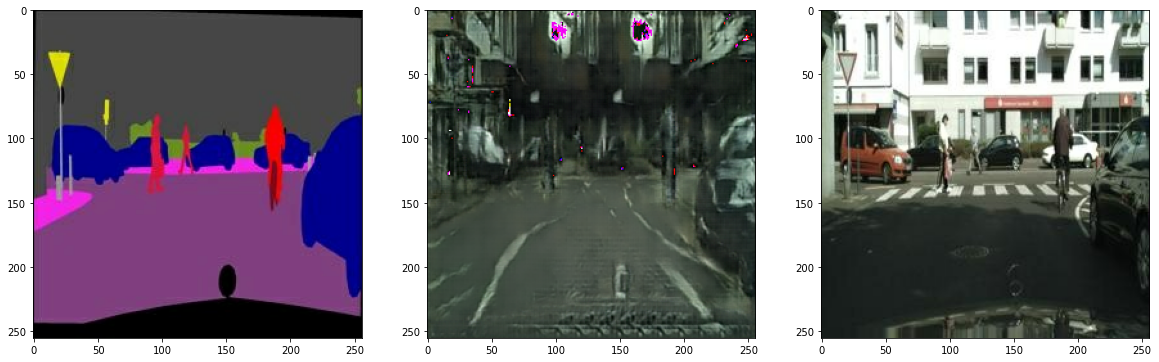

In [27]:
test_ind = 1
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'


f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 회고

Mission들을 수행
- mission 1에서는 5가지의 augmentation를 수행하였고, 2에서는 U-Net Generator를, 3에서는 val폴더 내의 이미지를 사용하였으며, 4에서는 스케치, 생성된 사진, 실제 사진 순서로 시각화하였고, 5에서 중간 손실 값에 대한 로그를 남기는데 성공하였다.



## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

- 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

- U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

- 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.